In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
#function to display grayscale image
def displayimage(image,num):
    plt.figure(num)
    plt.imshow(image, cmap = 'gray')
    plt.show()


In [3]:
def compress(image,size):
    fx = float(size)/(float(image.shape[0]))
    fy = float(size)/(float(image.shape[1]))
    small_image = cv2.resize(image,(size,size),fx,fy)
    #displayimage(small_image,1)
    #print (small_image.shape)
    return small_image

In [4]:
image = cv2.imread('./sudokuimage.png')
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#displayimage(imgray,0)
#print (imgray.shape)

imgray = cv2.GaussianBlur(imgray,(11,11),0) #blurring is used to make lines thick and reduce noise
#displayimage(imgray,0)
#print (imgray.shape)


In [5]:
thresh_image = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
#displayimage(thresh_image,0)
#image_area = thresh_image.shape[0] * thresh_image.shape[1]
thresh_image = cv2.bitwise_not(thresh_image) #so that background black white and lines becomes white
                                            #this is done because cv2.findcountours find white object on black background
#displayimage(thresh_image,1)

#kernel = np.asarray([[0,1,0],[1,1,1],[0,1,0]], dtype = uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
kernel[0][0] = kernel[0][2] = kernel[2][0] = kernel[2][2] = 0
thresh_image = cv2.dilate(thresh_image,kernel) #dilation is done to join the lines of grid, if broken after thresholding
#displayimage(thresh_image,2)

In [6]:
def rectify(h):
        ''' this function put vertices of square we got, in anticlockwise order because afterwards when we create a new board, we put it's coordinates in anticlockwise order '''
        h = h.reshape((4,2))
        hnew = np.zeros((4,2),dtype = np.float32)

        add = h.sum(axis = 1) #because, in a rectangle, top left will have min sum and bottom right will have max sum
        hnew[0] = h[np.argmin(add)]
        hnew[2] = h[np.argmax(add)]

        diff = np.diff(h,axis = 1) #in a rect, top right will have max difference, and bottom left will have min difference (in signed magnitude)
        hnew[1] = h[np.argmin(diff)]
        hnew[3] = h[np.argmax(diff)]

        return hnew

def rectify_new(h):
        ''' this function put vertices of square we got, in anticlockwise order because afterwards when we create a new board, we put it's coordinates in anticlockwise order '''
        hnew = np.zeros((4,2),dtype = np.float32)

        add = h.sum(axis = 1) #because, in a rectangle, top left will have min sum and bottom right will have max sum
        hnew[0] = h[np.argmin(add)]
        hnew[2] = h[np.argmax(add)]

        diff = np.diff(h,axis = 1) #in a rect, top right will have max difference, and bottom left will have min difference (in signed magnitude)
        hnew[1] = h[np.argmin(diff)]
        hnew[3] = h[np.argmax(diff)]

        return hnew

In [7]:
image_area = imgray.size
thresh_image, contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for i in contours:
    if cv2.contourArea(i)> image_area/2: # if area of box > half of image area, it is possibly the biggest blob
        peri = cv2.arcLength(i,True)
        approx_sudoku_board = cv2.approxPolyDP(i,0.02*peri,True)
        #cv2.drawContours(img,[approx],0,(0,255,0),2,cv2.CV_AA)
        break
#print (approx.shape)
#print (approx)
approx_sudoku_board=rectify(approx_sudoku_board)
#print (approx_sudoku_board)

In [8]:
dummy_board = np.array([ [0,0],[288,0],[288,288],[0,288] ],np.float32) 
#^^^ we created a dummy image of size 288,288 because each box is of 32x32(dataset for recognition) so dimension of sudoku will be 288.288

retval = cv2.getPerspectiveTransform(approx_sudoku_board,dummy_board) # apply perspective transformation
warped_board = cv2.warpPerspective(image,retval,(288,288))  # Now we get perfect colored square containing sudoku

final_sudoku_board = cv2.cvtColor(warped_board,cv2.COLOR_BGR2GRAY)

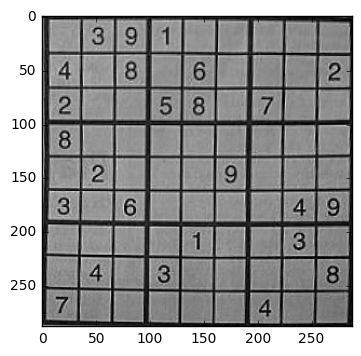

In [9]:
#displayimage(final_sudoku_board,0)
#print (final_sudoku_board.shape)
sharpen_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) #sharpening is done to make numerals and lines accurate for prediction
final_sudoku_board = cv2.filter2D(final_sudoku_board,-1,sharpen_kernel)
displayimage(final_sudoku_board,0)

In [10]:
image = final_sudoku_board.copy()
imgray = cv2.GaussianBlur(image,(11,11),0)
thresh_image = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
thresh_image = cv2.bitwise_not(thresh_image)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
kernel[0][0] = kernel[0][2] = kernel[2][0] = kernel[2][2] = 0
thresh_image = cv2.dilate(thresh_image,kernel)
#^^^ same procedure is applied as before because we need to find contours, so this procedure is very good for finding contours of lines and grids
#displayimage(thresh_image,0)

board_area = thresh_image.size
#print (board_area)
box_area = board_area/80.0 #should have been 81 but used 80 to remove error and avoid any box being left
#print (box_area)

In [11]:
thresh_image, contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cnt = 0
small_boxes = []
for i in contours:
    area = cv2.contourArea(i)
    if area>box_area or area < box_area/2: # if area of contour > box area, that means it isnt a box and neither should be too small compared to box area
        continue
    (x,y,w,h) = cv2.boundingRect(i)
    #image = cv2.rectangle(image, (x,y), (x+w, y+h), (0,0,255),2)
    #cnt += 1
    small_boxes.append([x,y,x+w,y+h]) #top left + bottom right

boxes = sorted(small_boxes,key = lambda x: (x[0],x[1])) 
#^^^ sorts on basis of first 2 keys, if arr1[0]<arr2[0] return arr1[0] else if arr1[0]==arr2[0], then check for 2nd value

side = box_area ** 0.5
side /= 1.5
#print (side)

prev = boxes[0][0]
for ix in range(1,len(boxes)): #because first box has already been considered to initialize prev
    if abs(boxes[ix][0]-prev)>side:
        prev = boxes[ix][0]
    else:
        boxes[ix][0] = prev
sm_boxes = sorted(boxes,key = lambda x: (x[0],x[1])) 
#print (sm_boxes,len(sm_boxes))

In [12]:
"""
for ix in sm_boxes:
    image = cv2.rectangle(image, (ix[0],ix[1]),(ix[2],ix[3]),(0,0,255),2)
displayimage(image,0)
"""

'\nfor ix in sm_boxes:\n    image = cv2.rectangle(image, (ix[0],ix[1]),(ix[2],ix[3]),(0,0,255),2)\ndisplayimage(image,0)\n'

In [27]:
number_images = []

for ix in sm_boxes:
    ########################################################################################
    dummy_board = np.array([ [0,0],[32,0],[32,32],[0,32] ],np.float32) 
    points = np.array([[ix[0],ix[1]],[ix[2],ix[1]],[ix[2],ix[3]],[ix[0],ix[3]]],np.float32)
    retval = cv2.getPerspectiveTransform(points,dummy_board)
    warped_board = cv2.warpPerspective(final_sudoku_board,retval,(32,32))
    ######################################################################################## is done to make each small box of size(32,32) for detection
    
    #####################################################################################################
    temp = cv2.adaptiveThreshold(warped_board,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15)
    #^^^threshold is applied to obtain black and white photo for digit recognition using ML
    number_images.append(temp)
    #####################################################################################################
    
#BORDERS ARE WHITENED OUT    
for ix in number_images:
    ix[:5,:] = 255
    ix[28:,:] = 255
    ix[:,:5] = 255
    ix[:,28:] = 255
    
#sudoku grid is stored in "number_images" in column major
"""
for ix in range(9):
    for iy in range(9):
        plt.imshow(number_images[ix*9 + iy],cmap = 'gray')
        plt.subplot(9,9,ix + 9*iy +1)
        #displayimage(number_images[ix],ix)
        #print (number_images[ix].shape)
displayimage(final_sudoku_board,1)
"""

"\nfor ix in range(9):\n    for iy in range(9):\n        plt.imshow(number_images[ix*9 + iy],cmap = 'gray')\n        plt.subplot(9,9,ix + 9*iy +1)\n        #displayimage(number_images[ix],ix)\n        #print (number_images[ix].shape)\ndisplayimage(final_sudoku_board,1)\n"